q-1 : implementing  a Neural Network.

In [0]:
import numpy as np
import pandas as pd
import io
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from numpy import savetxt
eps = np.finfo(float).eps

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/5/input_data/apparel-trainval.csv')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = shuffle(data).reset_index(drop=True)
data_train = data[:int(0.8 * len(data))]
data_test = data[int(0.8 * len(data)):]
print(data.shape)
print("Training data : ", data_train.shape)
print("Test data : ", data_test.shape)

(60000, 785)
('Training data : ', (48000, 785))
('Test data : ', (12000, 785))


In [0]:
def softmax(x):
    shift_x = x - np.array([np.max(x, axis=1)]).T
    exps = np.exp(shift_x)
    return exps / np.array([np.sum(exps, axis=1)]).T
    
def delta_softmax(x):
    soft = softmax(x)
    return soft * (1. - soft)

def sigmoid(x):
    return 1. / (1. + np.exp(-x))
  
def delta_sigmoid(x):
    sig = sigmoid(x)
    return sig * (1. - sig)
    
def relu(x):
    return np.maximum(x, 0.0, x) 
  
def delta_relu(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x
  
def tan_h(x):
    return np.tanh(x)
  
def delta_tan_h(x):
    return 1.0 - np.tanh(x)**2

def delta_mean_square_error(y_, y):
    return (y_ - y)

In [0]:
def one_hot_encode(y, unique_labels):
    y_mat = np.zeros((y.shape[0], len(unique_labels)))
    for i in range(len(y)):
        y_mat[i][y[i]] = 1
    return y_mat

def activation_func(function_name):
    fun = ""
    del_fun = ""
    if function_name == "relu":
        fun = relu
        del_fun = delta_relu
        
    elif function_name == "tanh":
        fun = tan_h
        del_fun = delta_tan_h
        
    elif function_name == "sigmoid":
        fun = sigmoid
        del_fun = delta_sigmoid
    return fun, del_fun

def cross_entropy(predictions, targets, epsilon = 1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions + eps))/N
    return ce

  
# def user_input():
#     layers = int(input("Enter the number of hidden layers: "))
#     neurons = []
#     for i in range(layers):
#         print("Enter the number of neurons in layer ", i, ": ")
#         temp = input()
#         neurons.append(int(temp))
#     batch_size = int(input("Enter the batch size: "))
#     epochs = int(input("Enter the number of epochs: "))
#     return layers, neurons, batch_size, epochs
  
def save_weights(best_weights):
    np.save('/content/gdrive/My Drive/Colab Notebooks/5/output_data/best_weights.npy', best_weights)
    
def load_weights():
    loaded_weights = np.load('/content/gdrive/My Drive/Colab Notebooks/5/output_data/best_weights.npy')
    return loaded_weights
  
def model_acc(model):
    test_x = data_test.iloc[:,1:]
    test_x = StandardScaler().fit_transform(test_x)
    
    predicted_y = model.test(test_x)
    predicted_y = np.argmax(predicted_y, axis=1)
    
    return accuracy_score(data_test.iloc[:,0], predicted_y)
  
def plot(act_funs, cost_dic, epochs):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    it = [i for i in range(epochs)]
    color = ['r','b','g']
    mark = ['o','+','>']
    ind = 0
    
    for f in act_funs:
        ax1.scatter(it, cost_dic[f], s = 10, color = color[ind], marker = mark[ind], label=f)
        ind += 1
    
    plt.legend(loc='upper right');
    plt.show()  

In [7]:
X = data_train.iloc[:,1:]
X = StandardScaler().fit_transform(X)
y = data_train.iloc[:,0]

class_labels = np.unique(y)
class_labels = class_labels.tolist()
y = one_hot_encode(y, class_labels)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
class NeuralNetwork:
    def __init__(self,layers, neurons, output_labels, features, batch_size, epochs, fun, reload, learning_rate=0.00001):
        self.fun, self.delta_fun = activation_func(fun)
        self.batch_size = batch_size
        self.epochs = epochs
        self.layers = layers
        self.learning_rate = learning_rate
        self.output_labels = output_labels
        if reload == 1:
            self.weights = load_weights()
        else:
          self.weights = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights)):
            if i == 0:
                _range =  np.sqrt(1. / features)
                self.weights[i] = np.random.uniform(-_range,_range,(features, neurons[i])) # weight matrix between input layers and hidden layer 1
            elif i == layers:
                _range =  np.sqrt(1. / neurons[i - 1])
                self.weights[i] = np.random.uniform(-_range,_range,(neurons[i - 1], len(output_labels))) #weight matrix between last hidden layer and output layer
            else:
                _range =  np.sqrt(1. / neurons[i - 1])
                self.weights[i] =  np.random.uniform(-_range,_range,(neurons[i-1], neurons[i]))
        
       
        
    def feed_forward(self,X):
        self.h_in = np.empty(layers + 1, dtype = object)
        self.h_out = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights)):
            if i == 0:
                self.h_in[i] = np.dot(X, self.weights[i])
                self.h_out[i] = self.fun(self.h_in[i])
            elif i == self.layers:
                self.h_in[i] = np.dot(self.h_out[i - 1], self.weights[i])
                self.h_out[i] = softmax(self.h_in[i])
            else:
                self.h_in[i] = np.dot(self.h_out[i - 1], self.weights[i]) 
                self.h_out[i] = self.fun(self.h_in[i])           
                
    def back_prop(self,X, y):
        delta_weights = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights) - 1, -1, -1): 
            if i == self.layers: 
                delta_weights[i] = np.multiply(delta_mean_square_error(self.h_out[-1], y), delta_softmax(self.h_in[-1]))
            else: 
                delta_weights[i] = np.multiply(np.dot(delta_weights[i+1], self.weights[i+1].T), self.delta_fun(self.h_in[i]))

        for i in range(layers + 1):
            if i == 0: 
                self.weights[i] -= self.learning_rate * np.dot(X.T, delta_weights[i])
            else:
                self.weights[i] -= self.learning_rate * np.dot(self.h_out[i-1].T, delta_weights[i])
      
    def train(self,X, y):
        all_costs = []
        for i in range(self.epochs):
            cost = 0
            for j in range(0, X.shape[0], self.batch_size):
                new_x = X[j:j+self.batch_size]
                new_y = y[j:j+self.batch_size]
                self.feed_forward(new_x)
                self.back_prop(new_x, new_y)
                cost += cross_entropy(self.h_out[-1], new_y)
            if i%10 == 0:    
                print(i,cost / self.batch_size)
            all_costs.append(cost / self.batch_size)
        return all_costs
            
    def test(self,test_x):
        self.feed_forward(test_x)
        y_ = self.h_out[-1]
        return y_

In [9]:
functions = ['sigmoid', 'tanh', 'relu']

layers = 1
neurons = [60] * layers
features = 784
batch_size = 500
epochs = 500
lr_dic = {'sigmoid':0.001,"tanh":0.00001,"relu":0.000001}
best_weights = 0
best_acc = 0
cost_dic = {}
best_fun = 0

for f in functions:
    model = NeuralNetwork(layers, neurons, class_labels, features, batch_size, epochs, f, 0, lr_dic[f])
    cost = model.train(X, y)
    acc = model_acc(model)
    if acc > best_acc:
        best_acc = acc
        best_fun = f
        save_weights(model.weights)
    print("For function ",f,"acccuracy is",acc, "cost is",cost)
    cost_dic[f] = cost

(0, 0.300110777877282)
(10, 0.09230641234348055)
(20, 0.08086833159231822)
(30, 0.07514003808862231)
(40, 0.07132316958053131)
(50, 0.0684281377634399)
(60, 0.06609027385515204)
(70, 0.06410403915369961)
(80, 0.06234932678505135)
(90, 0.060773025803038436)
(100, 0.059339285719029904)
(110, 0.0580183859461329)
(120, 0.0568014288004948)
(130, 0.05568065906815332)
(140, 0.05464335050626633)
(150, 0.053678219570153805)
(160, 0.052776568473877634)
(170, 0.05193592177429131)
(180, 0.05114343811772698)
(190, 0.05039416066807331)
(200, 0.049686402495516015)
(210, 0.049016809917209164)
(220, 0.048377045691568005)
(230, 0.047761242802423935)
(240, 0.04717774766875871)
(250, 0.046616863144661146)
(260, 0.046081011355050425)
(270, 0.04557046880427397)
(280, 0.045083928985814675)
(290, 0.044621337463527866)
(300, 0.04418147967688163)
(310, 0.04376086599794604)
(320, 0.0433618815130729)
(330, 0.04298077136309861)
(340, 0.0426136526550293)
(350, 0.042257401140782976)
(360, 0.04191505988064804)
(370, 

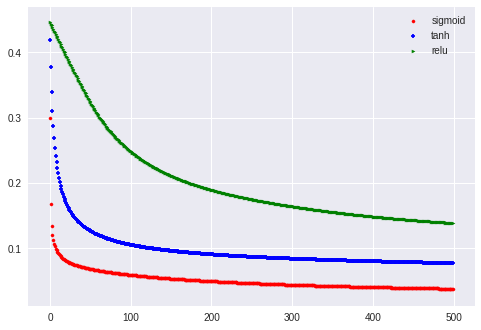

In [10]:
plot(functions, cost_dic, epochs)

In [0]:
def final_test():
    test_filename = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/5/input_data/apparel-test.csv')
    model = NeuralNetwork(layers, neurons, class_labels, features, batch_size, epochs, best_fun, 1, lr_dic[best_fun])
    pred = model.test(test_filename)
    pred = np.argmax(pred, axis = 1)
    savetxt('/content/gdrive/My Drive/Colab Notebooks/5/output_data/2018201034_prediction.csv', pred, fmt = "%d")

final_test()